# Analysis for reliability of CAMI processing

In [1]:
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
import numpy as np

In [2]:
def get_subject(institute, subject, sequence):
    if institute == 'CMI_1':
        dir = '../Data/fromCMI_1/'  
    elif institute == 'CMI_2':
        dir = '../Data/fromCMI_2/'
    else:
        dir = '../Data/fromKKI/OneDrive_1_5-29-2024/'
    
    xlxs = pd.ExcelFile(dir + subject + '.xlsx')
    if sequence in xlxs.sheet_names:
        df = pd.read_excel(xlxs, sequence).iloc[6:]
        df.columns = df.iloc[0]
        df = df.iloc[1:].reset_index(drop=True)
        df = df.dropna(axis=1, how='all')
        df.rename({' ':'Frame_num'}, inplace=True, axis=1)
        return df
    else:
        print('Sequence not found')
        return
    
sequences = ['seq3_PT1_100', 'seq1_PT_100', 'seq1_TR_60']
pilots = ['100_O1', '65656_O1', '99999_O1']

# Running the Ccorrelations: Pilot x Sequence

In [10]:
corrs = pd.DataFrame()

for pilot_subject in tqdm(pilots):
    for sequence in sequences:
        # get the data
        dat1 = get_subject('CMI_2', pilot_subject, pilot_subject + '_' + sequence)
        dat2 = get_subject('KKI', pilot_subject, pilot_subject + '_' + sequence)
        # Truncate so frames are aligned
        # First Frame
        first_frame = max(dat1.Frame_num.min(), dat2.Frame_num.min())
        dat1 = dat1[dat1.Frame_num >= first_frame]
        dat2 = dat2[dat2.Frame_num >= first_frame]

        # Last Frame
        last_frame = min(dat1.Frame_num.max(), dat2.Frame_num.max())
        dat1 = dat1[dat1.Frame_num <= last_frame]
        dat2 = dat2[dat2.Frame_num <= last_frame]
        # run the correlation
        df = pd.DataFrame()
        for joint in dat1.columns[1:]:
            dat1_joint = dat1[joint]
            dat2_joint = dat2[joint]
            # Calculate the correlation between the two datasets
            #corr = dat1_joint.corr(dat2_joint)
            corr = np.corrcoef(dat1_joint.astype(float).values, dat2_joint.astype(float).values)
#            df.loc[joint, 'correlation'] = corr
            df.loc[joint, 'correlation'] = corr[1][0]
        df['sequence'] = sequence
        df['pilot'] = pilot_subject

        corrs = pd.concat([corrs, df], axis=0)

100%|██████████| 3/3 [00:12<00:00,  4.03s/it]


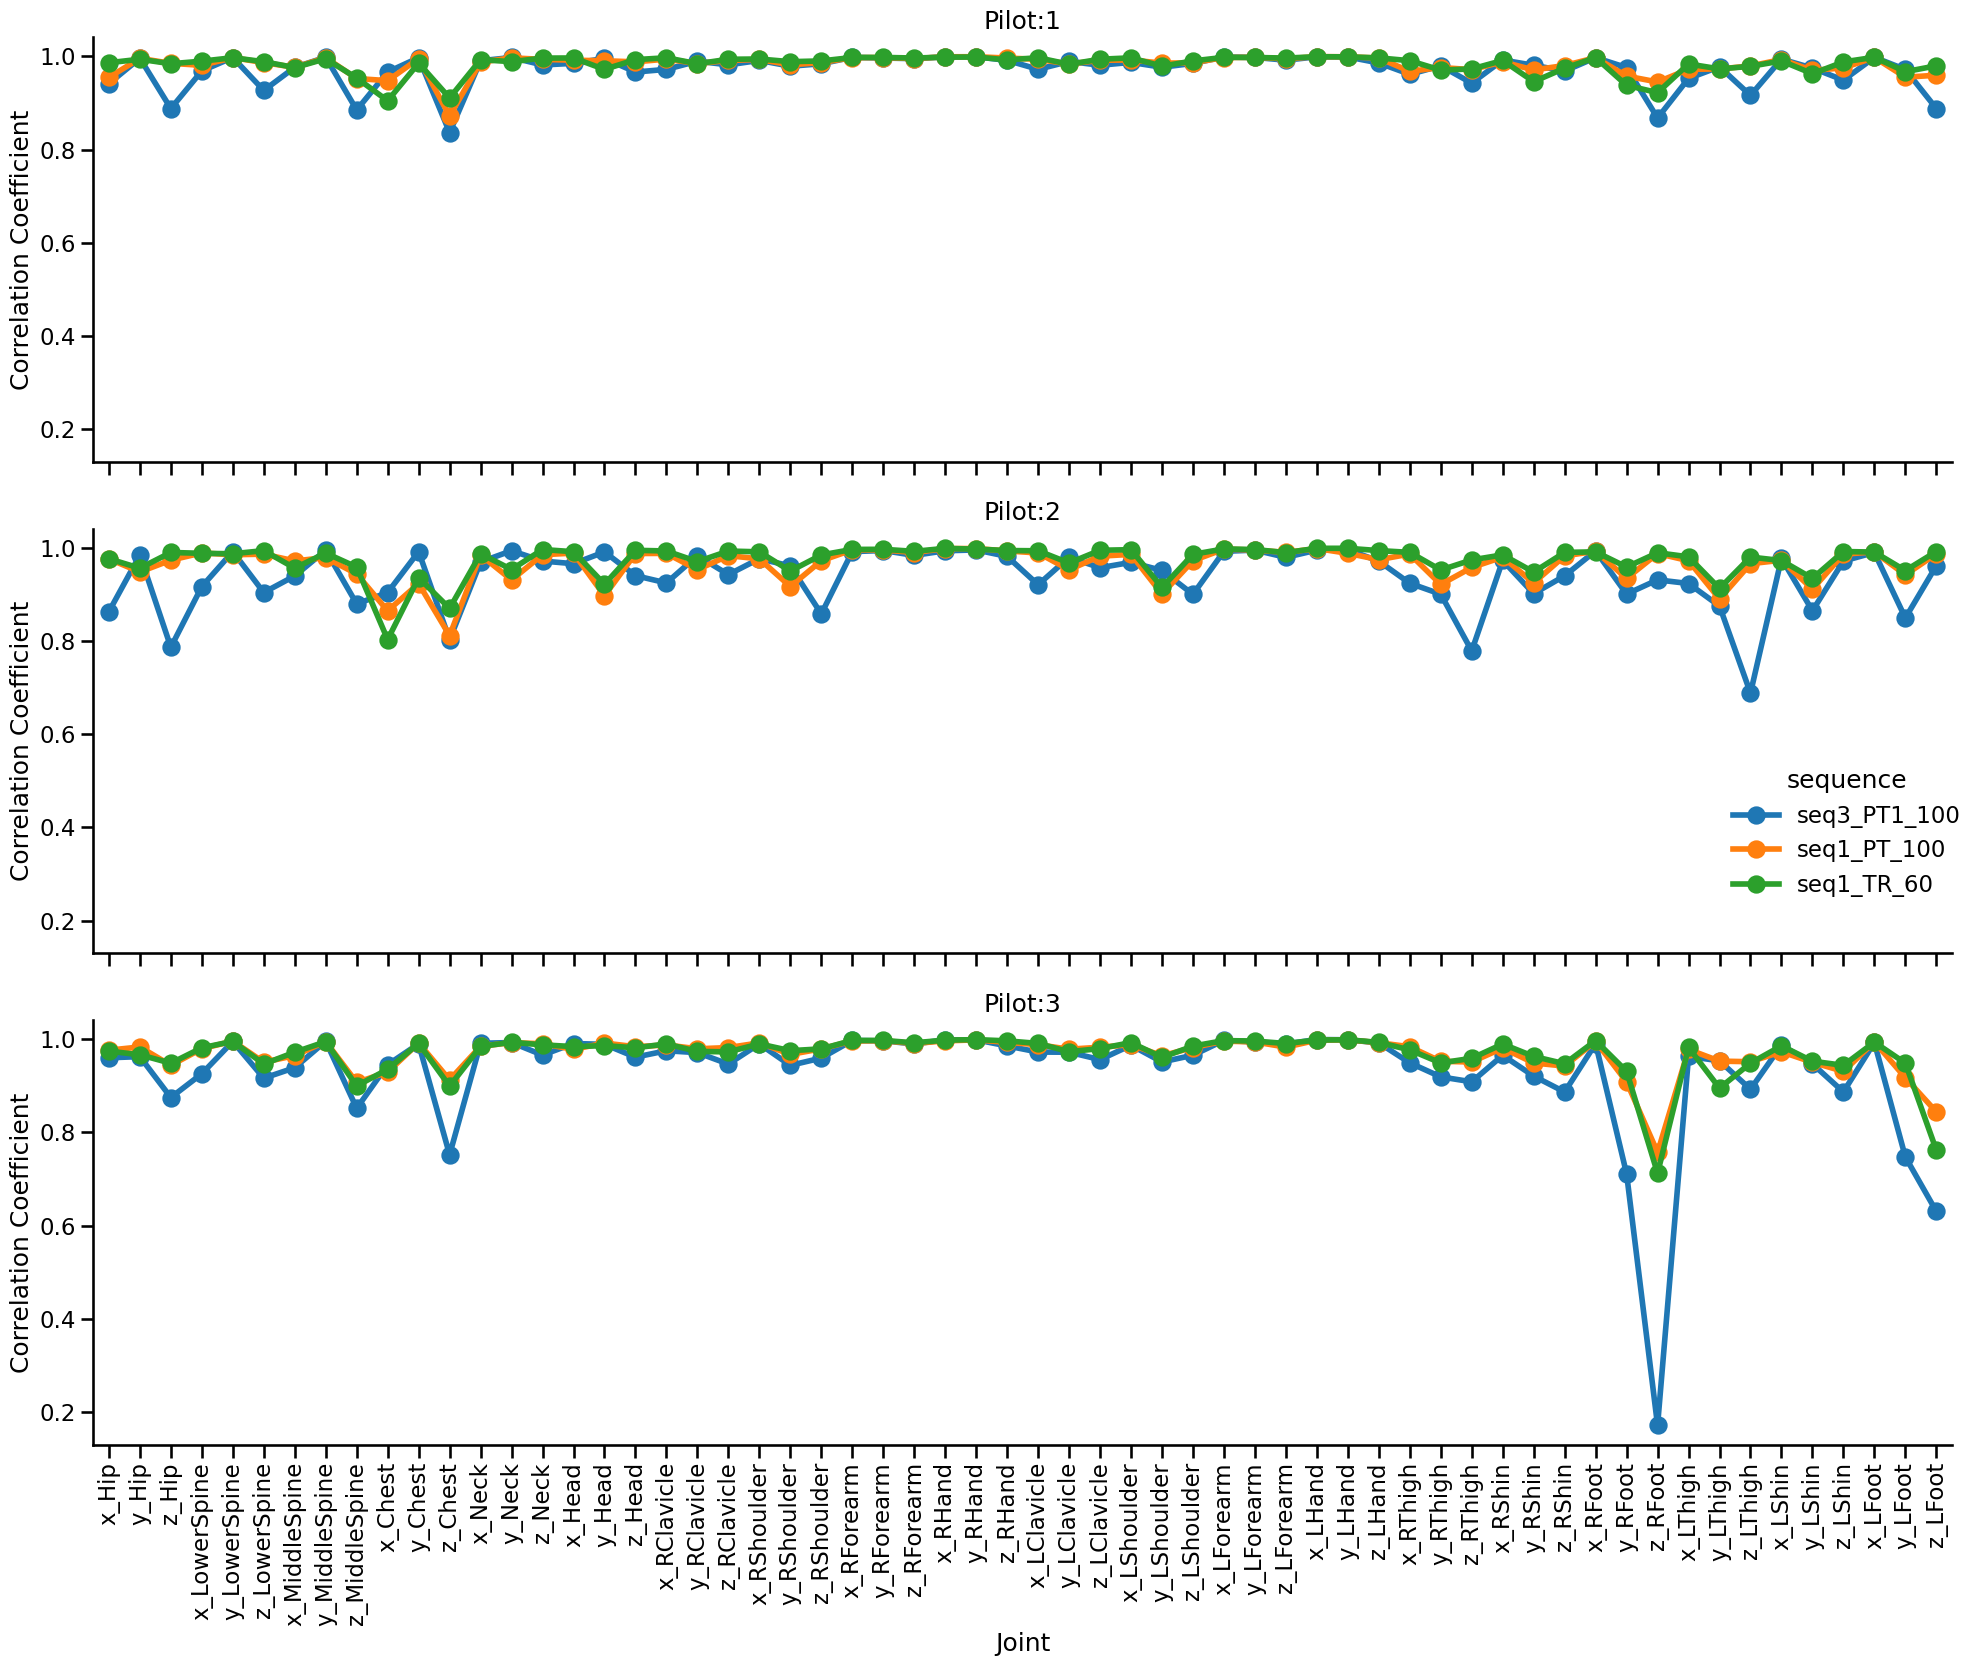

In [11]:
sns.set_context('talk')
g = sns.catplot(data=corrs, x=corrs.index, y='correlation', hue='sequence', kind='point', col='pilot', col_wrap=1)
# set figure size

g.fig.set_size_inches(20, 17)
# rotate the x axis labels on each plot
for i, ax in enumerate(g.axes):
    plt.sca(ax)
    plt.xticks(rotation=90);
    ax.title.set_text(f'Pilot:{i+1}')
# set the axes title
    plt.xlabel('Joint')
    plt.ylabel('Correlation Coefficient')

# set the title

plt.tight_layout()
#plt.suptitle(f'Correlation between CMI (Rater 1) and KKI for joint position.')
# set range of y axis between 0 and 1
#plt.ylim(0, 1.1);

## Percentage of variables > .90

In [12]:
corrs.groupby(['pilot', 'sequence']).mean()

correlation
pilot    sequence                 
100_O1   seq1_PT_100      0.982719
         seq1_TR_60       0.983220
         seq3_PT1_100     0.972194
65656_O1 seq1_PT_100      0.965082
         seq1_TR_60       0.973757
         seq3_PT1_100     0.938885
99999_O1 seq1_PT_100      0.967939
         seq1_TR_60       0.966387
         seq3_PT1_100     0.932595

In [18]:
sum(corrs.correlation.iloc[1:] > .9) #/ len(corrs.correlation.iloc[1:]) * 100
accuracy = pd.DataFrame()
for pilot_subject in pilots:
    acc = pd.DataFrame()
    for sequence in sequences:
        acc['pilot'] = pilot_subject
        acc['sequence'] = sequence
        acc['mean_corr']  = corrs.loc[(corrs.pilot == pilot_subject) & (corrs.sequence == sequence), 'correlation'].mean()
        acc['std_corr']  = corrs.loc[(corrs.pilot == pilot_subject) & (corrs.sequence == sequence), 'correlation'].std()
        

        

482

<Axes: xlabel='6', ylabel='6'>

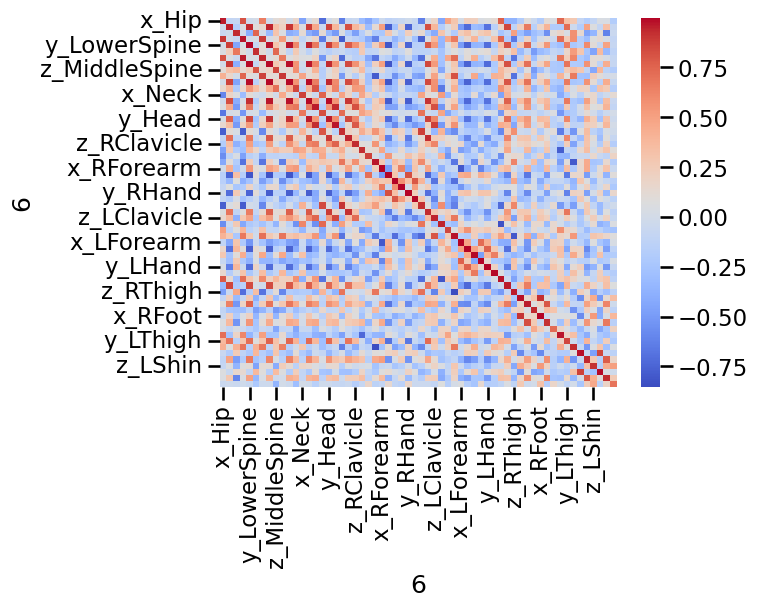

In [10]:
df = pd.DataFrame(columns=cmi_dat.columns[1:], index=cmi_dat.columns[1:])
#df.columns = cmi_dat.columns[1:]
#df.index = cmi_dat.columns[1:]
for joint in df.columns:
    for joint2 in df.index:
        cmi_joint = cmi_dat[joint]
        kki_joint = kki_dat[joint2]
        # Calculate the correlation between the two datasets
        corr = cmi_joint.corr(kki_joint)
        df.loc[joint, joint2] = corr

sns.heatmap(df.astype(float), cmap='coolwarm')

## List of Joints

In [4]:
joints = [x.split('_')[-1] for x in cmi_dat.columns][1:]
# get the unique joints 
joints = list(set(joints))
joints

['Head',
 'RThigh',
 'Neck',
 'RShin',
 'MiddleSpine',
 'LowerSpine',
 'LFoot',
 'RHand',
 'LForearm',
 'RForearm',
 'LShin',
 'Hip',
 'RFoot',
 'LClavicle',
 'LThigh',
 'Chest',
 'LHand',
 'RClavicle',
 'LShoulder',
 'RShoulder']

## Number of Frames: Site x Pilot Subject x Movement Sequence

In [9]:
# get the totaly number of frames for each sequence
frames = {}
for site in ['CMI_1', 'CMI_2', 'KKI']:
    frames[site] = {}
    for pilot_subject in tqdm(pilots):
        frames[site][pilot_subject] = {}
        for sequence in sequences:
            # get the data
            dat = get_subject(site, pilot_subject, pilot_subject + '_' + sequence)
            frames[site][pilot_subject][sequence] = dat.shape[0]

100%|██████████| 3/3 [00:06<00:00,  2.09s/it]


### Visualizing the number of frames

In [10]:
# visualize the nested dictionary Frames in a dataframe
frames_df = pd.DataFrame()
for site in frames.keys():
    for pilot_subject in frames[site].keys():
        for sequence in frames[site][pilot_subject].keys():
            frames_df.loc[pilot_subject + '_' + sequence, site] = frames[site][pilot_subject][sequence]

frames_df.reset_index(inplace=True)
frames_df.columns = ['mvmnt_sequence', 'CMI_1', 'CMI_2', 'KKI']
# plot these values as a pointplot
#sns.pointplot(data=frames_df, join=False, hue='mvmnt_sequence')
frames_df = frames_df.melt(id_vars='mvmnt_sequence').rename(columns={'variable':'rater', 'value':'frames'})
frames_df['pilot_num']= frames_df.mvmnt_sequence.str.split('_').str[0]
frames_df['mvmnt_seq'] = frames_df['mvmnt_sequence'].str.split('O1_').str[1]


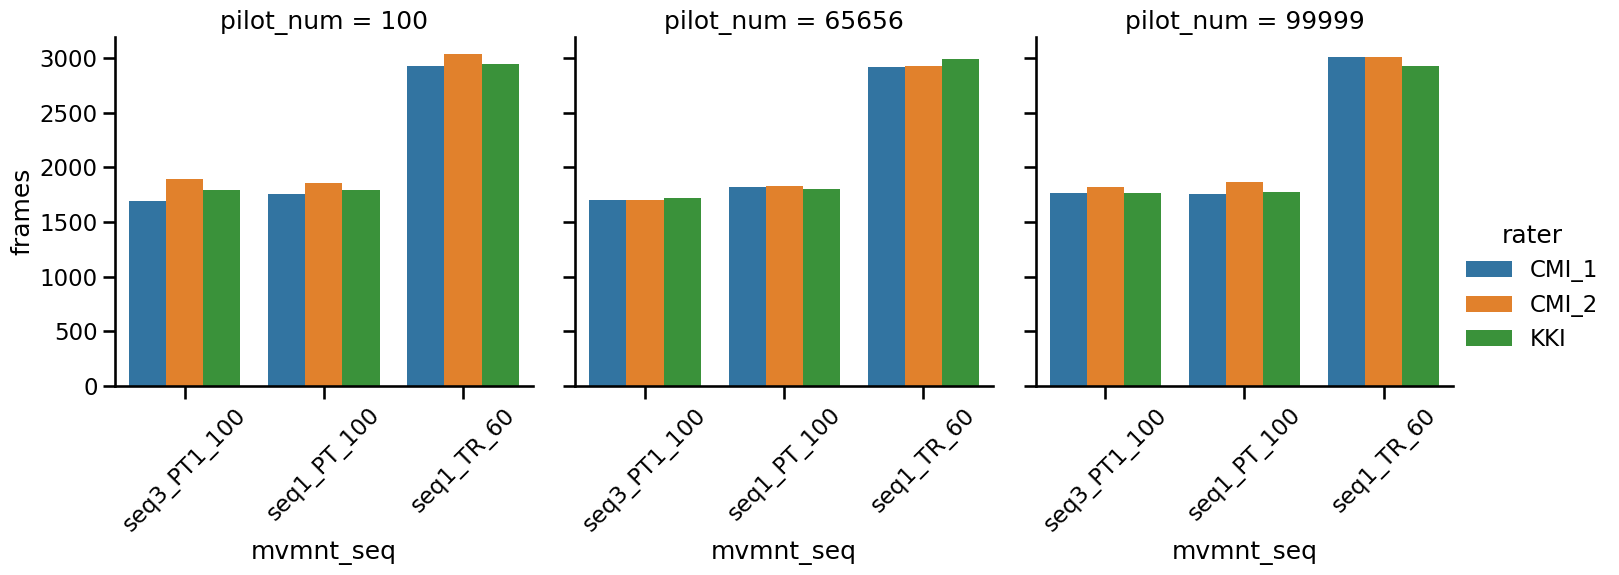

In [11]:
g = sns.catplot(data=frames_df, x='mvmnt_seq', y='frames', hue='rater', kind='bar', col='pilot_num')
g.set_xticklabels(rotation=45)
# set the xtickslabels
#   

#plt.xtickslabels(['p1_seq1', 'p1_seq2', 'p1_seq3', 'p2_seq1', 'p2_seq2', 'p2_seq3', 'p3_seq1', 'p3_seq2', 'p3_seq3'])

# Bland-Altman Plot

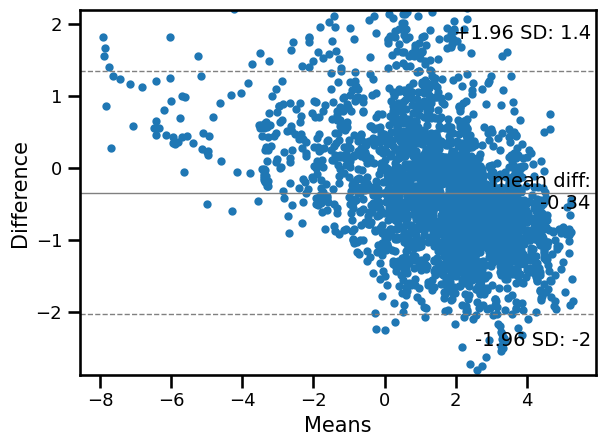

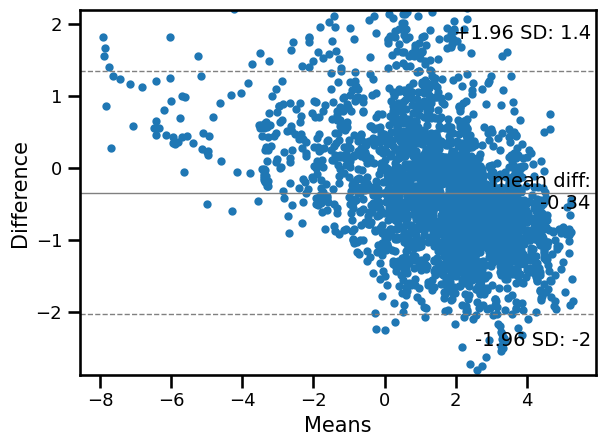

In [18]:
import statsmodels.api as sm

minsize = min(cmi_dat[cmi_dat.columns[3]].size, kki_dat[cmi_dat.columns[3]].size)

sm.graphics.mean_diff_plot(cmi_dat[cmi_dat.columns[3]].iloc[:minsize], kki_dat[cmi_dat.columns[3]].iloc[:minsize])

In [ ]:
corrs

In [ ]:
frames